## LandTrendr Implementation For Decadal Averaging of Spectral Indices

# Requirements: 

Python:

* geemap
* ee
* matplotlib
* numpy
* pandas
* oeel ** 

Other:
* Google Earth Engine Account

The LandTrendr algorithm is highly efficient and extensive tool with documentation at this link: https://emapr.github.io/LT-GEE/

This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2

** this package allows the user to run GEE modules directly without the pitfalls of translating JS to Python.

In [1]:
%config IPCompleter.use_jedi = False

import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

### save the date as a variable to use for version control

In [2]:
today = dt.today()
print("Today is: ", today)

Today is:  2023-03-15 20:40:37.318189


 # GEE Authentication
 
 - The ee.authenticate line is necessary the first time using ee (and roughly every week thereafter)
 - Authentication requires the user to log into their Earth Engine account which will provide the opportunity to copy and paste an a personal authentication code to this notebook granting access to the server. 
 - Authentication lasts for roughly one week, whereupon the "token required" error on the subsequent "ee.initialize" cell will signal the need to re-do the authentication step.
 - Simply comment and un-comment the ee.authenticate cell below when required
 
 
 ### Paste the Authetication code into the box below. 
 
 (press enter to save token, comment out this box until prompted again )


In [3]:
#ee.Authenticate()

In [4]:
geemap.ee_initialize()

### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available
* 


In [5]:
p = '..'

l_BE = pd.read_csv(f"{p}\Inputs\Version_2_20230214\BE.csv").catchment.tolist()
l_FR = pd.read_csv(f"{p}\Inputs\Version_2_20230214\FR.csv").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i


names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')

23 catchments processed for hydroclimatic variables:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']


### Load the EE package

The landTrendr package is developed to construct timeseries of landsat imagery for the purpose of land cover detection. The base parameters are optimised for deforestation event detection. 

This utilisation of the GEE asset (with apache license i.e. free for use) allows for the latest version of LandTrendr to be used. In contrast to early versions this allows for the utilisation of the Landsat Collection 2 reprocessing effort with improvements in cloud masking capabilities. Primarily we use "ltgee.buildSRcollection"

If the JS module is faulty then the cell below will not load. 

In [6]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v6.js')

#ltgee.availability  #all functions within the javascript module


IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the aut/or: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 08/03/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)


## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository


In [7]:
asset_dir = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW'

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

startYear = 1984

endYear = 2022

startDay = '06-20'

endDay = '08-31'

maskThese = ['cloud', 'shadow', 'snow',]

bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 


## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- The area is calculated of each shape and ranked per area, assuming that the largest is the most computationally expensive
- This is done so that we can iterate from smallest to largest, or the opposite, should any memory issues become apparent.

In [8]:
table = ee.FeatureCollection(f"projects/mohanrahan/assets/{asset_dir}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':'EPSG:4326',
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)


Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

df1 = down.loc[down['Stations_M'].isin(names)]

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]


gdf = geemap.ee_to_pandas(Filtered_Sorted)

if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx')

Map.addLayer(Filtered_Sorted, {}, 'table')
Map.centerObject(Filtered_Sorted, 7)

Map

,pixel_area,area_km2,mk_ndvi_s,_Siltsum,_Sandmean,mk_ndvi_p,mk_ndvi_ba,_Claysum,area2,DN,...,_Slopecoun,_Slopeme_1,_Claymean,mk_ndvi_Ta,_Slopesum,_Areasum,_Slopemean,mk_ndvi_z,lat_cntrd,mk_ndvi_sl
system_index,,,,,,,,,,,,,,,,,,,,,
00000000000000000018,1589.533689,1584.214049,313,2173402.0,32.470143,2.600534121377507e-08,ndvi,902463.0,1589520866,4,...,2855,0.100024,19.805188,0.7195402298850575,285.567280,10622,0.100024,5.566401673092492,49.774258,0.001341795283705413
0000000000000000001d,1372.050234,1367.694860,251,1937981.0,25.415430,8.1861141973949e-06,ndvi,967797.0,1372078404,3,...,2385,0.074491,24.839510,0.5770114942528736,177.661758,7068,0.074491,4.460257750875394,49.164286,0.001645973131225845
0000000000000000001e,1347.055442,1342.927162,65,1869726.0,24.334453,0.2535263593015791,ndvi,990604.0,1347037137,101,...,2325,0.069893,26.200910,0.1494252873563219,162.500744,2363,0.069893,1.141825984224101,48.556343,0.0004379326552890796
0000000000000000000d,1306.148656,1301.658056,,2041932.0,28.065466,,,682999.0,1306173925,1401,...,2375,0.078770,18.029645,,187.078770,24790,0.078770,,50.334882,
0000000000000000001b,973.084708,969.907519,149,1345654.0,26.895371,0.008279048973595771,ndvi,687913.0,973089809,201,...,1727,0.072896,24.725505,0.3425287356321839,125.891296,3478,0.072896,2.640472588518234,49.491089,0.00088735322481866
00000000000000000012,907.666741,904.622343,341,1205992.0,36.663526,1.311754926902609e-09,ndvi,446231.0,907648045,5,...,1628,0.093857,17.089116,0.7839080459770115,152.798851,8120,0.093857,6.065950541190537,49.792315,0.001936215088446068
0000000000000000000e,548.303165,546.432054,355,841430.0,29.865626,2.688977929210523e-10,ndvi,268922.0,548294740,6,...,969,0.066195,16.989197,0.8160919540229885,64.142957,5946,0.066195,6.315724975239559,50.045699,0.00218191137699244
0000000000000000001f,442.962882,441.640949,,593421.0,25.779350,,,324055.0,442966205,1016,...,765,0.059739,26.201083,,45.700221,773,0.059739,,48.287026,
00000000000000000019,405.813979,404.503520,211,567106.0,27.737042,0.0001792357743730655,ndvi,270701.0,405836111,41,...,694,0.063084,23.346356,0.4850574712643678,43.780269,2904,0.063084,3.746616510735331,49.541173,0.00110162061886552


Map(center=[49.771185229680235, 5.34768540569512], controls=(WidgetControl(options=['position', 'transparent_b…

In [9]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def image_band_mean(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.mean(),
    'region': aoi,
    'scale': scale,
    'band': band+'_mean',
    })
    
    return chart_ts_region.dataframe

def image_band_median(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': band+'_median',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_5(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([5]),
    'region': aoi,
    'scale': scale,
    'band': band+'_p5',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_95(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([95]),
    'region': aoi,
    'scale': scale,
    'band': band+'_p95',
    })
    
    return chart_ts_region.dataframe

    
def bands_reduced_toexcel(imcol, scale, ind, band):
    '''
    Takes the bands and returns excel sheets of each catchment:
    ->mean, median, percentile, 
    '''
    df_mean = image_band_mean(imcol, scale, band)
    df_median = image_band_median(imcol, scale, band)
    df_pct5 = image_band_percentile_5(imcol, scale, band)
    df_pct95 = image_band_percentile_95(imcol, scale, band)
    
    
    df_mean.reset_index()
    df_median.reset_index()
    df_pct5.reset_index()
    df_pct95.reset_index()
    
    
    joined= df_mean.join(df_median, how='inner', lsuffix='mean', rsuffix='median')
    joined_pct = df_pct5.join(df_pct95, how='inner', lsuffix='p5', rsuffix='p95')
   
    annual = joined.join(joined_pct, how='inner')
    annual.to_excel(f'../Outputs/{dataset}/timeseries/{ind}_annual_{band}.xlsx')

def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds):
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i, yc, classified, trainingClassImage, ms, classImageYear, name, accuracy):

    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pivoted.iloc[0, 0:5].sum()
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted

def normalize (image):
    '''
    This function is used to convert band values to a range between 0 and 1 via normalisation,
    this is typically slow and no improvement to accuracy has been observed yet by its implementation.
    
    The 5 minute loop for an example catchment e.g. Chooz 2012, goes from 
    '''
    bandNames = image.bandNames()
    
def saveClassifierToCSV(classifier, name, yc):
    decisionTrees = ee.List(classifier.explain().get('trees')).getInfo()
    folder='Trees'

    var = f'../Outputs/{dataset}/{folder}/'

    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

    ml.trees_to_csv(decisionTrees, f'../Outputs/Meuse/Trees/{name}_{yc}')

## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [10]:
scale = 1000 # define the pixel size for reducing, in meters, initially high to reduce comp time


id_ls = 'used_images'
SR_t = 'SR_timeseries'
RF_c = 'RF_classification/'


folder_list = [id_ls, SR_t, RF_c]

for folder in folder_list:
    
    var = f'../Outputs/{dataset}/{folder}'
    
    if not os.path.exists(var):
        print('created')
        os.makedirs(var)


The loop goes through all shapes in the WFLOW derived catchment list maximising data collection and also stress testing the workflow for memory exceedences
The classification scheme is run at the same time as the surface reflectance data gathering

17:06:39.102404 ,  cancelled after 14 mins...
remove the classify function and rerun


In [11]:
'''
Tuning of hyperParameters 'rfParams' is accomplished using this link:

https://code.earthengine.google.com/fb0850cf3a8712cef6da822186fb2be1

JSON printed in the console was plotted in python to find the optimal parameters for 
this purpose. Specifically two years were plotted for the Chooz catchment 1990 vs 2018.

The optimal parameter for each year was identified using overall accuaracy and overall kappa score
Optimal parameter set for all years was determined to be between each.

TODO: Allow user selected RF parameters

'''

classLoopParams = {'dataset':'CORINE', 
               'trainingClassLevel':1,
               'customClassLevels':None,
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
              }

t0 = dt.today()

classArea_df = pd.DataFrame()

#sys_index = ['0000000000000000000e'] #Treignes 00000000000000000018

sys_index = ['00000000000000000018']

print(f'begin loop: {t0}')

for i, ind in enumerate(sys_index):
    '''
    TODO: add Kappa, producers and consumers accuracy to the return
    TODO: Tune the hyperparameters and save the resulting classifiers
    '''
    
    
    name = df1.loc[ind].Stations_M
    
    area = df1.loc[ind].area_km2
    
    t1 = dt.today()
    
    print(f'\n{i+1}/{len(sys_index)} {t1}\nDataset: {dataset}, \nCatchment: {name}, \nSurface Reflectance Processing ...\n')
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, ['slcOff'])#.map(clip_collection) #much slower when clipped
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    # col = ee.ImageCollection(ltgee.LAIcol(startYear, endYear, startDay, endDay, aoi)) 
    
    #bands_reduced_toexcel(ee.ImageCollection(annual_med_calc), scale, ind, 'B1')
    
    #bands_reduced_toexcel(col, col.first().projection().nominalScale().getInfo(), ind, 'LAI')
    
    '''
    
    Which images are used in creating the annual composites?
    -> return as a list of Landsat image IDs ** 
    ** can be used for exclusion if image quality is suboptimal upon later inspection.. important for small sample cases.
    
    '''
    
    id_key = 'idList'
    
    masked_col_key = 'collection'
    
#     GetCollectionID = ltgee.getCollectionIDlist(startYear, endYear, startDay, endDay, aoi)
    
#     im_id_list = GetCollectionID[id_key]
    
#     image_list = pd.DataFrame({f'{name}': im_id_list.getInfo()})
    
#     image_list.to_csv(f'../Outputs/{dataset}/used_images/{ind}_imageList.csv')
    
    t2 = dt.today()
    
    print(f'step 1: Surface reflectance exported: {t2} \nTime taken: {t2-t1}')
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        
        year_classified = [1990, 2000, 2006, 2012, 2018]   
        # year_classified = [1990]   
        
        for j, yc in enumerate(year_classified):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            if yc >= 1984 and yc < 1999:
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classImageYear = 2012

            elif yc >= 2015:
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
            
            print(yc)
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first()
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), classLoopParams['dataset'], classLoopParams['trainingClassLevel'], aoi)
            
            
            #TODO: reproject to 30m native resolution
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(clipped, aoi)
        
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, imageToClassify, classLoopParams['numClasses'], classLoopParams['split'], classLoopParams['tileScale'], aoi, 'weighted')
            
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            
            # option to normalize image is offered but not used since the accuracy is not improved and it slows the workflow significantly
            #
            print('classifying...')
            
            #classifier training with predefined number of trees using training points
            classifier = ltgee.classifier(imageToClassify, training)
            
            t6 = dt.today()
            print('saving...')
            #saving decision trees for later use
            # saveClassifierToCSV(classifier, name, yc)
            
            #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            #assess the accuracy using the testing points, see where the confusion occurs
            accuracy = testing.classify(classifier).errorMatrix('landcover', 'classification').accuracy().getInfo()
            
            print('accuracy:', accuracy)
            '''
            return tuple of important stuff
            
            (year classified, year trained, accuracy, corine area:[1-5], masked area 6, classified area:[1-5], masked area 6,)
            
            '''

            df = dataframeAreas(i, j, classified, trainingClassImage, ms, classImageYear, name, accuracy)
            
            # df.to_csv(f'../Outputs/{dataset}/RF_classification/{ind}_classes.csv')
            
            classArea_df = classArea_df.append(df)
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    if ind == sys_index[0]:
        break



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-03-15 20:40:45.004536

1/1 2023-03-15 20:40:45.006533
Dataset: Meuse, 
Catchment: Chooz, 
Surface Reflectance Processing ...

step 1: Surface reflectance exported: 2023-03-15 20:40:46.477559 
Time taken: 0:00:01.471026

step 2: Initialize classification routine: 2023-03-15 20:40:46.477559
1990
classifying...
saving...


KeyboardInterrupt: 

# Output of Saved Decision Trees

begin loop: 2023-03-15 14:02:04.675621

1/1 2023-03-15 14:02:04.677569
Dataset: Meuse, 
Catchment: Chooz, 
Surface Reflectance Processing ...

step 1: Surface reflectance exported: 2023-03-15 14:02:05.826460 
Time taken: 0:00:01.148891

step 2: Initialize classification routine: 2023-03-15 14:02:05.826460

1990 --> accuracy: 0.8401888064733648

2000 --> accuracy: 0.8533960995292535

2006 --> accuracy: 0.8609625668449198

2012 --> accuracy: 0.85546875

2018 --> accuracy: 0.8529411764705882

step2: Done: 2023-03-15 14:16:07.113375, time taken: 0:14:01.286915


END LOOP: Full routine finished: 2023-03-15 14:16:07.113375 
Time taken: 0:14:02.437754

In [ ]:
accuracy

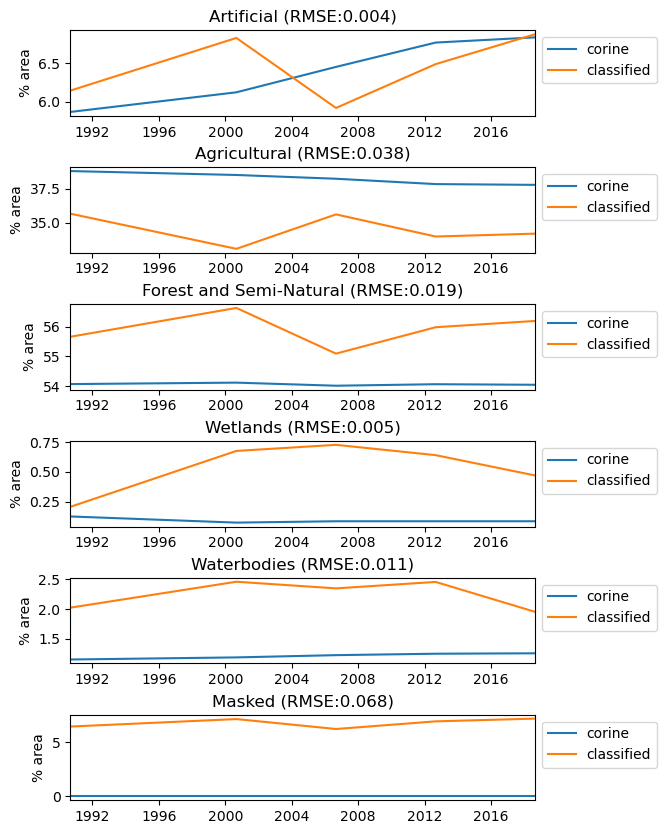

In [92]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']
area_norm = classArea_df.catchment.area
corine = [classArea_df.area_CORINE.iloc[:, i]/area_norm for i in range(len(classArea_df.area_CORINE.keys().values))]
rf = [classArea_df.area_RF.iloc[:, i]/area_norm for i in range(len(classArea_df.area_RF.keys().values))]

def rmse(y_true, y_pred):
    """
    Calculate the root mean squared error between two series of data.
    
    Parameters:
    y_true (array-like): The true values of the dependent variable.
    y_pred (array-like): The predicted values of the dependent variable.
    
    Returns:
    float: The root mean squared error between y_true and y_pred.
    """
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the RMSE
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))

    return rmse


def NSE(observed, simulated):
    """
    Computes the Nash-Sutcliffe Efficiency (NSE) between two series of data.
    
    Parameters:
    observed (array-like): The observed values of the dependent variable.
    simulated (array-like): The simulated values of the dependent variable.
    
    Returns:
    float: The Nash-Sutcliffe Efficiency (NSE) between the observed and simulated series.
    """
    # Convert inputs to numpy arrays
    observed = np.array(observed)
    simulated = np.array(simulated)

    # Calculate the mean of the observed values
    mean_observed = np.mean(observed)

    # Calculate the numerator and denominator of the NSE equation
    numerator = np.sum((simulated - observed)**2)
    denominator = np.sum((observed - mean_observed)**2)

    # Calculate the NSE
    nse = 1 - (numerator / denominator)

    return nse

    
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(6,10))


# loop through the subplots and plot the data
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        ax.plot(corine[i]*100, label='corine')
        ax.plot(rf[i]*100, label='classified')
        ax.set_title(f'{class_name[i]} (RMSE:{rmse(corine[i], rf[i]):.3f})')
        ax.set_xlim(corine[i].keys().values[0], corine[i].keys().values[-1])
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('% area')

    elif i == 1:
        ax.plot(corine[i]*100, label='corine')
        ax.plot(rf[i]*100, label='classified')
        ax.set_title(f'{class_name[i]} (RMSE:{rmse(corine[i], rf[i]):.3f})')
        ax.set_xlim(corine[i].keys().values[0], corine[i].keys().values[-1])
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('% area')

    elif i == 2:
        ax.plot(corine[i]*100, label='corine')
        ax.plot(rf[i]*100, label='classified')
        ax.set_title(f'{class_name[i]} (RMSE:{rmse(corine[i], rf[i]):.3f})')
        ax.set_xlim(corine[i].keys().values[0], corine[i].keys().values[-1])
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('% area')

    elif i == 3:
        ax.plot(corine[i]*100, label='corine')
        ax.plot(rf[i]*100, label='classified')
        ax.set_title(f'{class_name[i]} (RMSE:{rmse(corine[i], rf[i]):.3f})')
        ax.set_xlim(corine[i].keys().values[0], corine[i].keys().values[-1])
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('% area')

    elif i == 4:
        ax.plot(corine[i]*100, label='corine')
        ax.plot(rf[i]*100, label='classified')
        ax.set_title(f'{class_name[i]} (RMSE:{rmse(corine[i], rf[i]):.3f})')
        ax.set_xlim(corine[i].keys().values[0], corine[i].keys().values[-1])
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('% area')

    else:
        ax.plot(corine[i]*100, label='corine')
        ax.plot(rf[i]*100, label='classified')
        ax.set_title(f'{class_name[i]} (RMSE:{rmse(corine[i], rf[i]):.3f})')
        ax.set_xlim(corine[i].keys().values[0], corine[i].keys().values[-1])
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_ylabel('% area')


# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# show the figure
plt.show()

In [19]:
Map.addLayer(trainingClassImage, {'bands':['landcover'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}, 'Classes')
Map.addLayer(imageToClassify, {'bands':['B3','B2','B1'], 'min':0, 'max':1200}, 'RGB')

Map

Map(bottom=11445.0, center=[49.771185229680235, 5.34768540569512], controls=(WidgetControl(options=['position'…

In [21]:
classifier = ltgee.classifier(imageToClassify, training)

In [22]:
classifier

### classArea_df = pd.read_excel('../Outputs/meuse/RF_classification/classifier_search.xlsx', header=[0,1], index_col=0, parse_dates=True)
classArea_df.keys()

In [ ]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    classArea_df.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [ ]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

In [ ]:

fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.set_ylim(0.6, 0.9)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

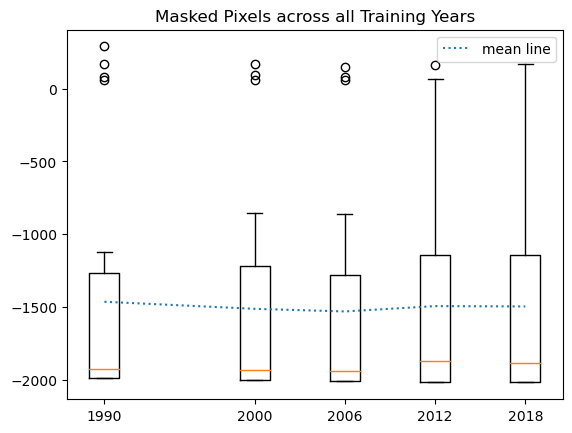

In [223]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

1589.5336892619698

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map